In [1]:
!pip install requests
!pip install beautifulsoup4
!pip install pandas
!pip install nltk
!pip install scikit-learn
!pip install python-pptx

In [36]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import numpy as np
import string
import logging
import nltk
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pptx import Presentation
from pptx.util import Inches
import requests
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import inspect
import pickle

In [37]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vedik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vedik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\vedik\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [38]:
#Load dataset
# Load the dataset
file_path = r'C:\Users\vedik\Downloads\all_reviews_with_ratings_and_titles_multiple_products.csv'
dataset = pd.read_csv(file_path, encoding='ISO-8859-1')
print(dataset.shape)


(5001, 5)


In [39]:
dataset.head(100)

,ï»¿Product Title,Review Title,Review Date,Reviews,Ratings
0,Intel Core I5 12400F 12 Gen Generation Desktop...,5.0 out of 5 stars\nVery Great Processor . . .,Reviewed in India on 24 April 2024,The processor was very power efficient i devel...,5.0 out of 5 stars
1,Intel Core I5 12400F 12 Gen Generation Desktop...,5.0 out of 5 stars\nBest CPU for Budget Ballers.,Reviewed in India on 15 June 2024,This processor is great mid to high range budg...,5.0 out of 5 stars
2,Intel Core I5 12400F 12 Gen Generation Desktop...,5.0 out of 5 stars\nThanku,Reviewed in India on 1 July 2024,Thanku Appario you send me best cpu,5.0 out of 5 stars
3,Intel Core I5 12400F 12 Gen Generation Desktop...,4.0 out of 5 stars\nNo discrete graphics in th...,Reviewed in India on 18 February 2024,"This will not work without graphic card, So be...",4.0 out of 5 stars
4,Intel Core I5 12400F 12 Gen Generation Desktop...,5.0 out of 5 stars\nBest Budget Cpu,Reviewed in India on 26 June 2024,Budget cpu for gamers and creators,5.0 out of 5 stars
...,...,...,...,...,...
95,Intel Core I5 12400F 12 Gen Generation Desktop...,No review title,Reviewed in the United Kingdom on 26 April 2023,I am not a gamer but like to keep reasonably u...,5.0 out of 5 stars
96,Intel Core I5 12400F 12 Gen Generation Desktop...,No review title,Reviewed in France on 22 June 2024,TrÃ¨s bon rapport qualitÃ©/prix pour un usage ...,5.0 out of 5 stars
97,Intel Core I5 12400F 12 Gen Generation Desktop...,No review title,Reviewed in Italy on 12 May 2024,"Ottimo qualitÃ prezzo,vedremo nel tempo",5.0 out of 5 stars
98,Intel Core I5 12400F 12 Gen Generation Desktop...,No review title,Reviewed in Germany on 6 June 2024,Sorry fÃ¼r schreiben bin ich zu faul. Aber all...,4.0 out of 5 stars


In [40]:
def clean_and_tokenize(text):
    # Example of a simple cleaning and tokenization function
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    tokens = text.split()  # Tokenize by splitting on spaces
    
    return tokens


In [41]:
print("Sample 'Review Date' values:")
print(dataset['Review Date'].head(20))


Sample 'Review Date' values:
0        Reviewed in India on 24 April 2024
1         Reviewed in India on 15 June 2024
2          Reviewed in India on 1 July 2024
3     Reviewed in India on 18 February 2024
4         Reviewed in India on 26 June 2024
5         Reviewed in India on 16 June 2024
6     Reviewed in India on 26 December 2023
7        Reviewed in India on 24 March 2024
8          Reviewed in India on 14 May 2024
9         Reviewed in India on 7 April 2024
10    Reviewed in India on 14 November 2023
11     Reviewed in India on 28 January 2024
12    Reviewed in India on 18 November 2023
13    Reviewed in India on 30 November 2023
14    Reviewed in India on 27 December 2023
15     Reviewed in India on 3 November 2023
16     Reviewed in India on 5 November 2023
17        Reviewed in India on 13 July 2023
18       Reviewed in India on 20 April 2022
19     Reviewed in India on 17 October 2023
Name: Review Date, dtype: object


In [42]:
# Apply cleaning and tokenization to 'Review Title' and 'Reviews'
dataset['Review Title'] = dataset['Review Title'].apply(lambda x: ' '.join(clean_and_tokenize(str(x))))
dataset['Reviews'] = dataset['Reviews'].apply(lambda x: ' '.join(clean_and_tokenize(str(x))))

# Function to extract numeric ratings from the ratings string
def extract_numeric_rating(rating_str):
    match = re.search(r'\d+\.\d+', str(rating_str))
    if match:
        return float(match.group())
    return None  # Return None if no match is found or if input is not a string
# Extract numeric ratings
dataset['Ratings'] = dataset['Ratings'].apply(extract_numeric_rating)



# Ensure all values in 'Review Date' are strings
#dataset['Review Date'] = dataset['Review Date'].astype(str)

# Function to extract the country from the review date string
def extract_country(date_str):
    match = re.match(r'Reviewed in (.+?) on', date_str)
    return match.group(1) if match else None

# Function to extract and parse the date from the review date string
def extract_and_parse_date(date_str):
    match = re.search(r'on (\d+ \w+ \d+)', date_str)
    if match:
        try:
            return pd.to_datetime(match.group(1), format='%d %B %Y')
        except ValueError:
            return None
    return None

# Extract the country and review date
dataset['Country'] = dataset['Review Date'].apply(lambda x: extract_country(x) if isinstance(x, str) else None)
dataset['Review Date'] = dataset['Review Date'].apply(lambda x: extract_and_parse_date(x) if isinstance(x, str) else None)



# Fill missing values with empty strings
dataset = dataset.fillna('')


In [43]:
# Display the cleaned dataset
print("Cleaned dataset:")
print(dataset.head(100))


Cleaned dataset:
                                     ï»¿Product Title  \
0   Intel Core I5 12400F 12 Gen Generation Desktop...   
1   Intel Core I5 12400F 12 Gen Generation Desktop...   
2   Intel Core I5 12400F 12 Gen Generation Desktop...   
3   Intel Core I5 12400F 12 Gen Generation Desktop...   
4   Intel Core I5 12400F 12 Gen Generation Desktop...   
..                                                ...   
95  Intel Core I5 12400F 12 Gen Generation Desktop...   
96  Intel Core I5 12400F 12 Gen Generation Desktop...   
97  Intel Core I5 12400F 12 Gen Generation Desktop...   
98  Intel Core I5 12400F 12 Gen Generation Desktop...   
99  Intel Core I5 12400F 12 Gen Generation Desktop...   

                                         Review Title Review Date  \
0       5.0 out of 5 stars Very Great Processor . . .  2024-04-24   
1     5.0 out of 5 stars Best CPU for Budget Ballers.  2024-06-15   
2                           5.0 out of 5 stars Thanku  2024-07-01   
3   4.0 out of 5 stars

In [44]:
# Additional steps to ensure the dataset is ready for further analysis
print("\nData after cleaning and preprocessing:")
print(dataset.head())
print("\nSummary statistics:")
print(dataset.describe())


Data after cleaning and preprocessing:
                                    ï»¿Product Title  \
0  Intel Core I5 12400F 12 Gen Generation Desktop...   
1  Intel Core I5 12400F 12 Gen Generation Desktop...   
2  Intel Core I5 12400F 12 Gen Generation Desktop...   
3  Intel Core I5 12400F 12 Gen Generation Desktop...   
4  Intel Core I5 12400F 12 Gen Generation Desktop...   

                                        Review Title Review Date  \
0      5.0 out of 5 stars Very Great Processor . . .  2024-04-24   
1    5.0 out of 5 stars Best CPU for Budget Ballers.  2024-06-15   
2                          5.0 out of 5 stars Thanku  2024-07-01   
3  4.0 out of 5 stars No discrete graphics in thi...  2024-02-18   
4                 5.0 out of 5 stars Best Budget Cpu  2024-06-26   

                                             Reviews  Ratings Country  
0  The processor was very power efficient i devel...      5.0   India  
1  This processor is great mid to high range budg...      5.0   India 

In [45]:
# Check for unique values in the 'Product Title' column
unique_product_titles = dataset['ï»¿Product Title'].unique()
print("Unique product titles:", unique_product_titles)

Unique product titles: ['Intel Core I5 12400F 12 Gen Generation Desktop Pc Processor 6, Cpu with 18Mb Cache and Up to 4.40 Ghz Clock Speed Ddr5 and Ddr4 Ram Support Lga 1700 Socket, Micro Atx'
 'Intel Core i3-10105F LGA1200 Desktop Processor 4 Cores 8 Threads up to 4.40GHz 6MB Cache'
 'Intel Core i5-12400 Desktop Processor 18M Cache, up to 4.40 GHz LGA 1700 Socket'
 'Intel Core i3 12100F 12th Gen Generation Desktop PC Processor 4 CPU with 12MB Cache and up to 4.30 GHz Clock Speed LGA 1700 Socket'
 'Intel Core i3-10100F 10th Generation LGA1200 Desktop Processor 4, 4 Cores 8 Threads up to 4.30GHz 6MB Cache'
 'Intel Core i5-12600K Desktop Processor 10 (6P+4E) Cores up to 4.9 GHz Unlocked Socket LGA 1700 600 Series Chipset 125W'
 'Intel Core i7-13700K Desktop Processor 16 cores (8 P-cores + 8 E-cores) 30M Cache, up to 5.4 GHz Socket LGA 1700'
 'IntelÂ® Core i5-10400 Processor (12M Cache, up to 4.30 GHz) BGA 437 Socket'
 'IntelÂ® Coreâ\x84¢ i9-13900KS Processor 36M Cache, up to 6.00 GHz'
 '

C:\Users\vedik\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 132 (\x84) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


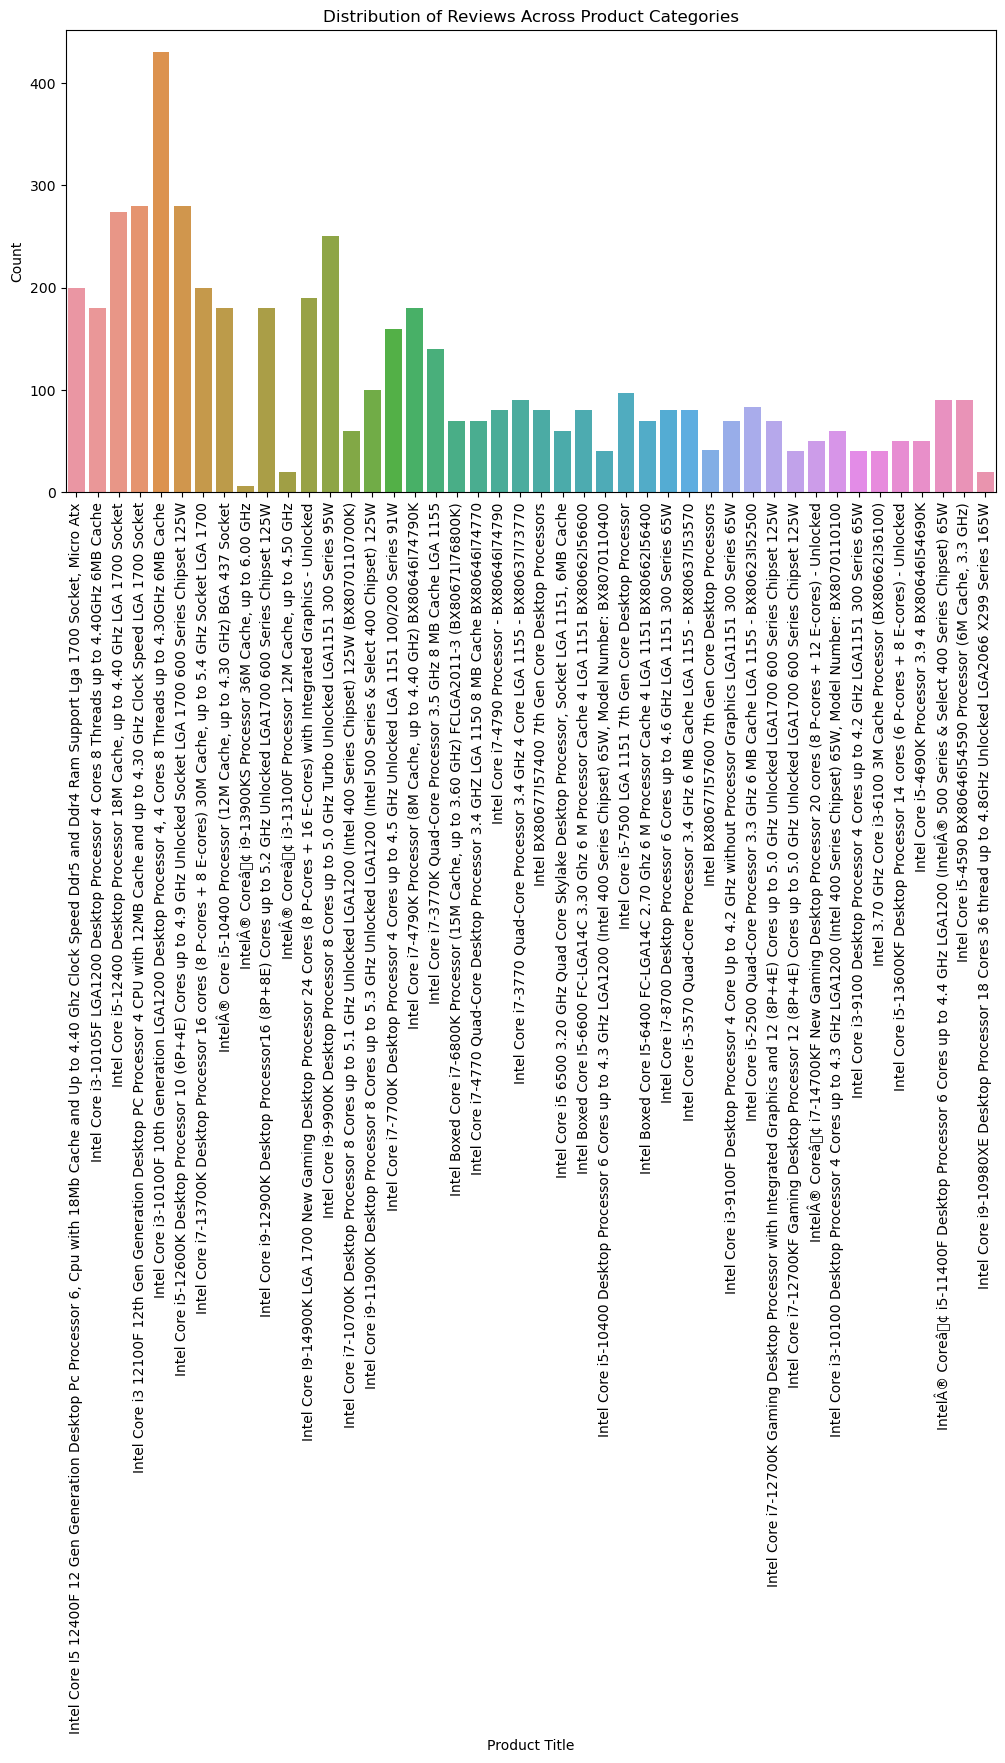

In [46]:
# Plot the distribution of reviews across product categories
plt.figure(figsize=(12, 6))
sns.countplot(x='ï»¿Product Title', data=dataset)
plt.title('Distribution of Reviews Across Product Categories')
plt.xlabel('Product Title')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

In [47]:
# Splitting the dataset into training and test sets
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)


In [48]:
# Vectorization
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train = vectorizer.fit_transform(train_data['Reviews'])
X_test = vectorizer.transform(test_data['Reviews'])


In [49]:
# Encoding the target labels
encoder = LabelEncoder()
encoder.fit(dataset['Ratings'])  
y_train = encoder.fit_transform(train_data['Ratings'])
y_test = encoder.transform(test_data['Ratings'])


In [50]:
#Distinct values of 'rating' and its count  

print(f"Rating value count: \n{dataset['Ratings'].value_counts()}")

Rating value count: 
Ratings
5.0    3671
4.0     739
1.0     285
3.0     191
2.0     115
Name: count, dtype: int64


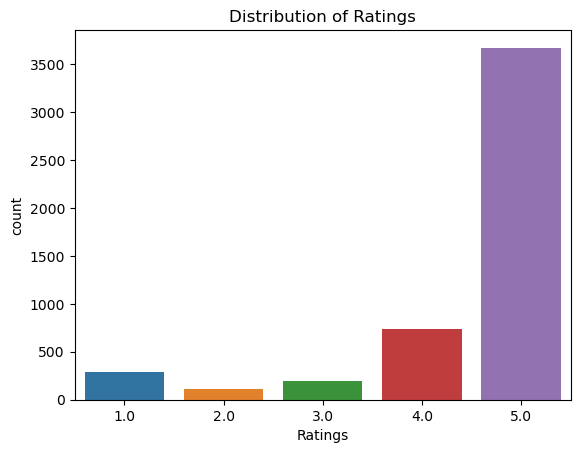

In [51]:
# Distribution of Ratings
sns.countplot(x='Ratings', data=dataset)
plt.title('Distribution of Ratings')
plt.show()

Rating value count - percentage distribution: 
Ratings
5.0    73.41
4.0    14.78
1.0     5.70
3.0     3.82
2.0     2.30
Name: count, dtype: float64


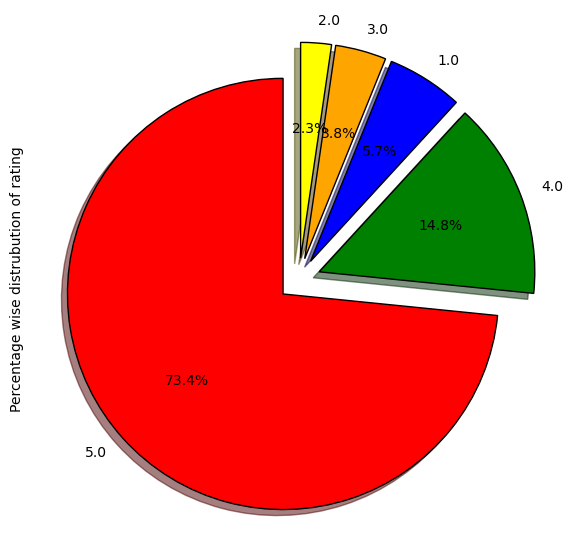

In [54]:
#Finding the percentage distribution of each rating - we'll divide the number of records for each rating by total number of records

print(f"Rating value count - percentage distribution: \n{round(dataset['Ratings'].value_counts()/dataset.shape[0]*100,2)}")

#In the form of piechart (ratings diistribution)
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green', 'blue','orange','yellow')

wp = {'linewidth':1, "edgecolor":'black'}

tags = dataset['Ratings'].value_counts()/dataset.shape[0]


## Dynamically create the explode tuple
explode = tuple([0.1] * len(tags))


tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of rating')

from io import  BytesIO

graph = BytesIO()

fig.savefig(graph, format="png")
plt.show()

In [55]:
#Distinct values of 'product' and its count 

import ast


# Print the value counts for the 'color' column
print(f"Variation value count: \n{dataset['ï»¿Product Title'].value_counts()}")


Variation value count: 
ï»¿Product Title
Intel Core i3-10100F 10th Generation LGA1200 Desktop Processor 4, 4 Cores 8 Threads up to 4.30GHz 6MB Cache                                                               430
Intel Core i3 12100F 12th Gen Generation Desktop PC Processor 4 CPU with 12MB Cache and up to 4.30 GHz Clock Speed LGA 1700 Socket                                        280
Intel Core i5-12600K Desktop Processor 10 (6P+4E) Cores up to 4.9 GHz Unlocked Socket LGA 1700 600 Series Chipset 125W                                                    280
Intel Core i5-12400 Desktop Processor 18M Cache, up to 4.40 GHz LGA 1700 Socket                                                                                           274
Intel Core i9-9900K Desktop Processor 8 Cores up to 5.0 GHz Turbo Unlocked LGA1151 300 Series 95W                                                                         250
Intel Core I5 12400F 12 Gen Generation Desktop Pc Processor 6, Cpu with 18Mb Cache and Up

C:\Users\vedik\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 132 (\x84) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


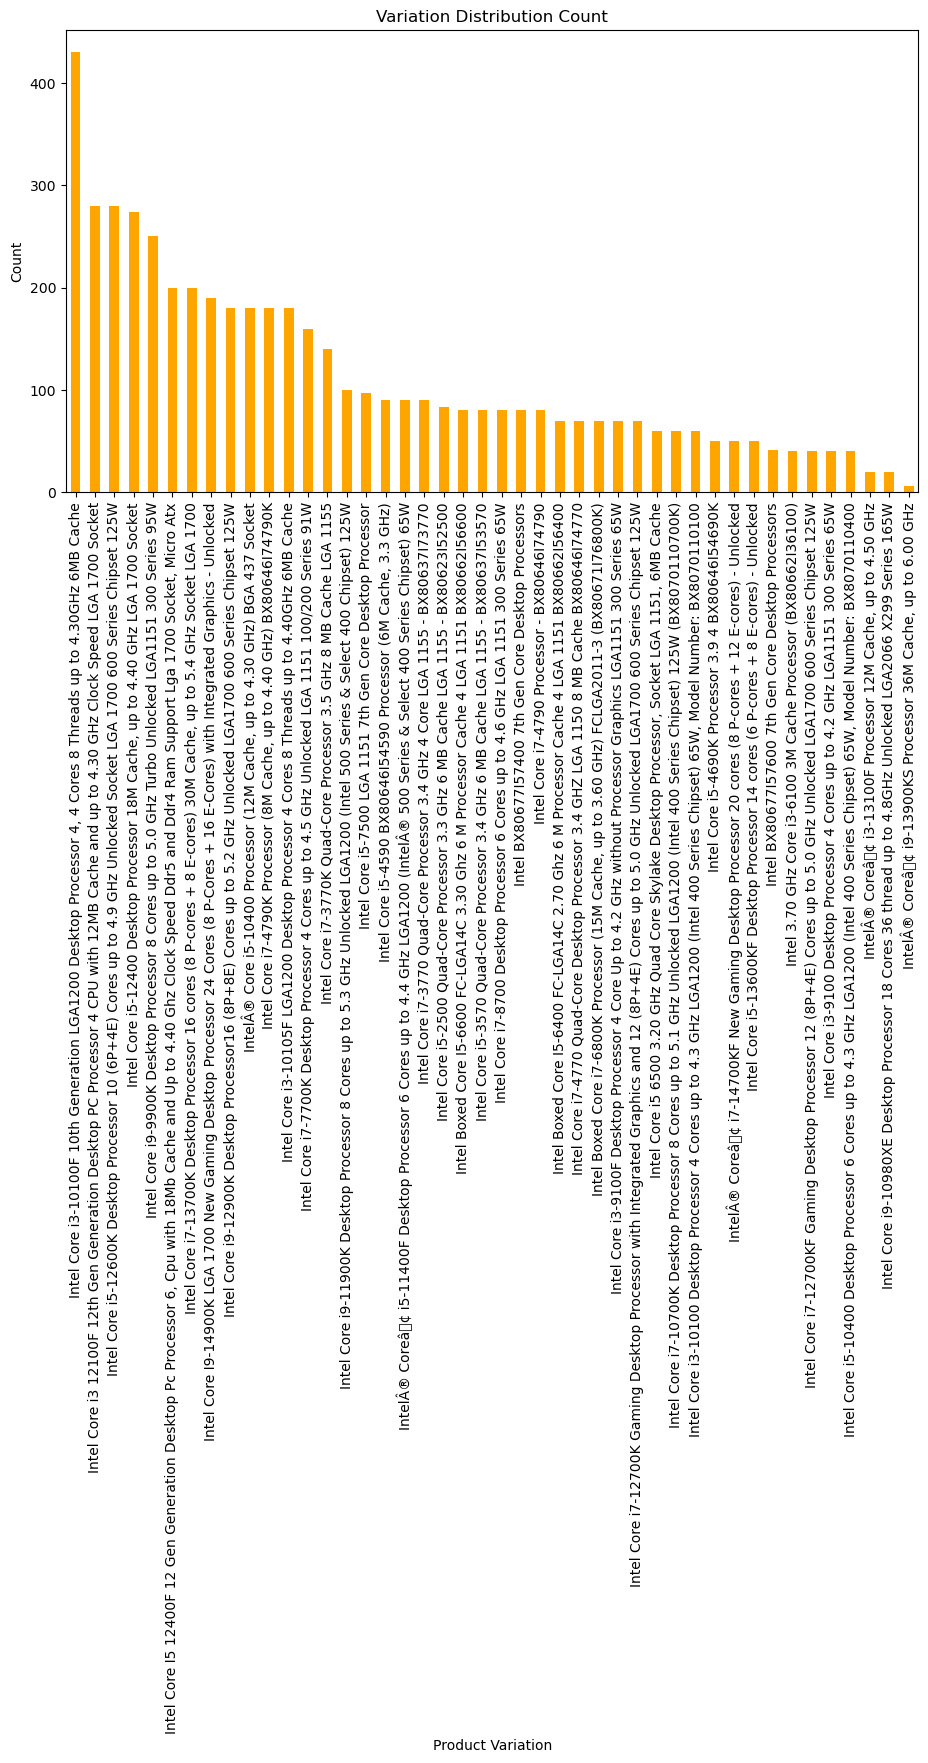

In [56]:
# Bar graph to visualize the total counts of each variation
dataset['ï»¿Product Title'].value_counts().plot.bar(color='orange',figsize=(11,6))
plt.title('Variation Distribution Count')
plt.xlabel('Product Variation')
plt.ylabel('Count')
# Rotate x-axis labels for better readability
#plt.xticks(rotation=45, ha='right')  # Rotate labels by 45 degrees and align them to the right
#plt.tight_layout()
plt.show()

In [57]:
#Finding the percentage distribution of each variation - we'll divide the number of records for each variation by total number of records

print(f"Variation value count - percentage distribution: \n{round(dataset['ï»¿Product Title'].value_counts()/dataset.shape[0]*100,2)}")


Variation value count - percentage distribution: 
ï»¿Product Title
Intel Core i3-10100F 10th Generation LGA1200 Desktop Processor 4, 4 Cores 8 Threads up to 4.30GHz 6MB Cache                                                               8.60
Intel Core i3 12100F 12th Gen Generation Desktop PC Processor 4 CPU with 12MB Cache and up to 4.30 GHz Clock Speed LGA 1700 Socket                                        5.60
Intel Core i5-12600K Desktop Processor 10 (6P+4E) Cores up to 4.9 GHz Unlocked Socket LGA 1700 600 Series Chipset 125W                                                    5.60
Intel Core i5-12400 Desktop Processor 18M Cache, up to 4.40 GHz LGA 1700 Socket                                                                                           5.48
Intel Core i9-9900K Desktop Processor 8 Cores up to 5.0 GHz Turbo Unlocked LGA1151 300 Series 95W                                                                         5.00
Intel Core I5 12400F 12 Gen Generation Desktop Pc Processo

In [58]:
#Mean rating accorsding to variation in color
dataset.groupby('ï»¿Product Title')['Ratings'].mean()


ï»¿Product Title
Intel 3.70 GHz Core i3-6100 3M Cache Processor (BX80662I36100)                                                                                                            4.750000
Intel BX80677I57400 7th Gen Core Desktop Processors                                                                                                                       3.787500
Intel BX80677I57600 7th Gen Core Desktop Processors                                                                                                                       4.756098
Intel Boxed Core I5-6400 FC-LGA14C 2.70 Ghz 6 M Processor Cache 4 LGA 1151 BX80662I56400                                                                                  4.442857
Intel Boxed Core I5-6600 FC-LGA14C 3.30 Ghz 6 M Processor Cache 4 LGA 1151 BX80662I56600                                                                                  4.562500
Intel Boxed Core i7-6800K Processor (15M Cache, up to 3.60 GHz) FCLGA2011-3 (BX80671I768

C:\Users\vedik\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 132 (\x84) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


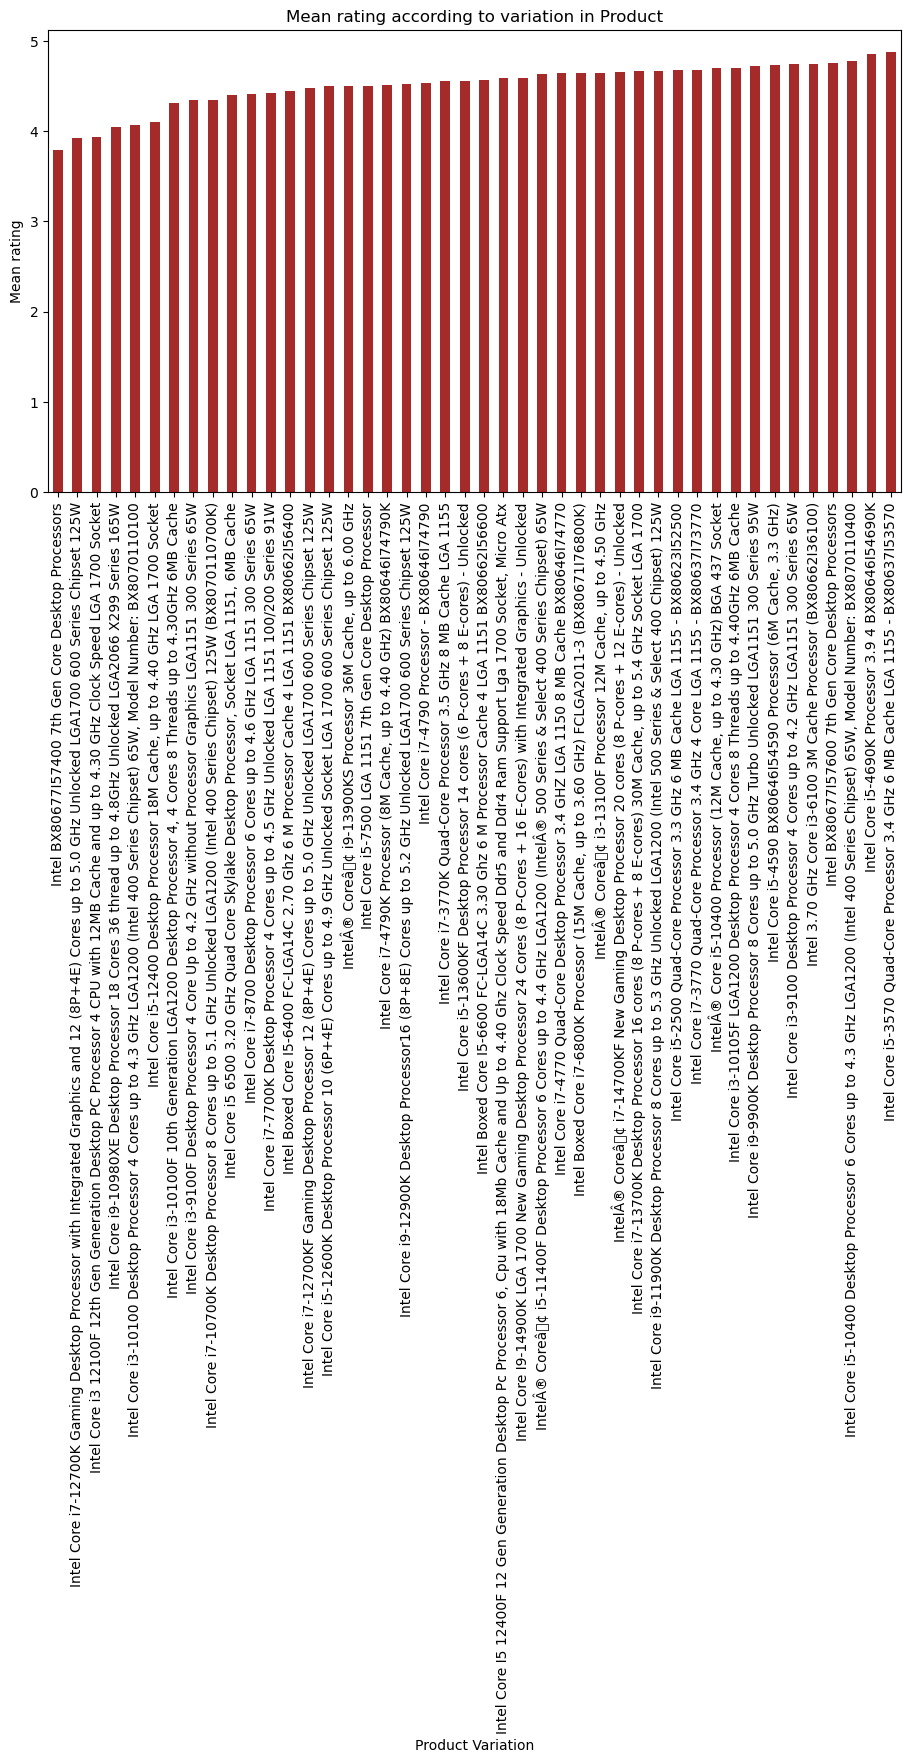

In [59]:
#Mean rating accorsding to variation in color
dataset.groupby('ï»¿Product Title')['Ratings'].mean().sort_values().plot.bar(color = 'brown', figsize=(11, 6))
plt.title("Mean rating according to variation in Product")
plt.xlabel('Product Variation')
plt.ylabel('Mean rating')
plt.show()

C:\Users\vedik\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\vedik\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


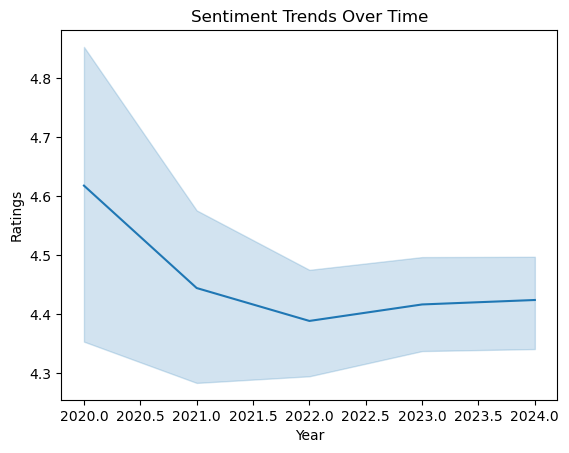

In [60]:
# Sentiment Trends Over Time
dataset['Year'] = dataset['Review Date'].dt.year
sns.lineplot(data=dataset, x='Year', y='Ratings')
plt.title('Sentiment Trends Over Time')
plt.show()

In [61]:
# Parse 'Review Date' to extract month and year
dataset['Year-Month'] = pd.to_datetime(dataset['Review Date'], errors='coerce').dt.to_period('M')


In [62]:
# Trend of Reviews Over Time
review_trends = dataset.groupby('Year-Month').size()


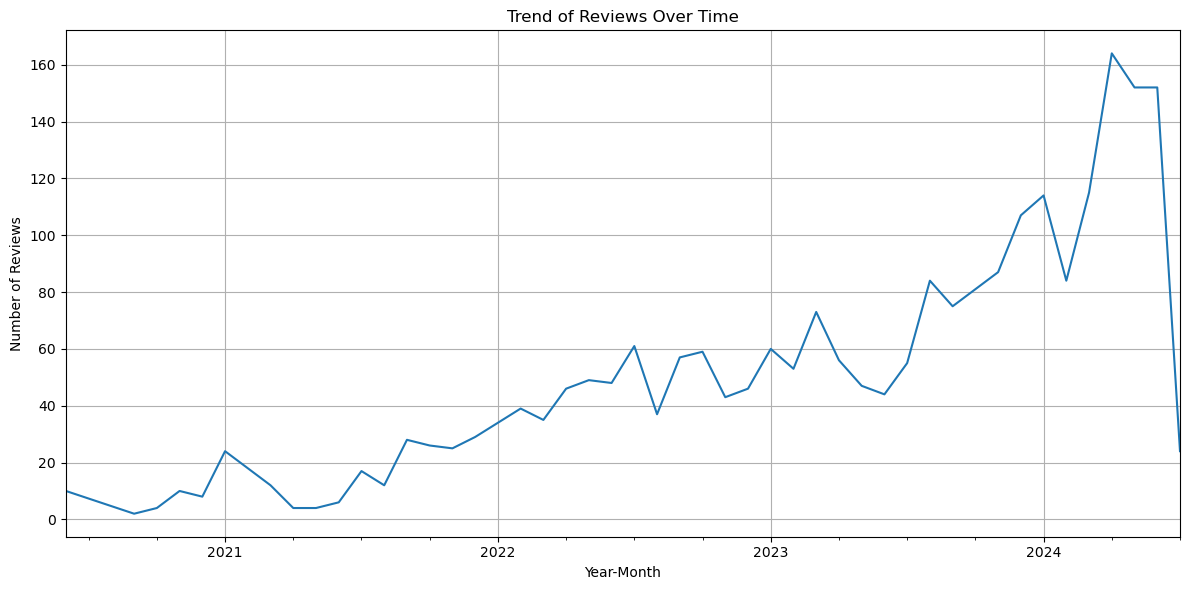

In [63]:
# Create plot for trend analysis
plt.figure(figsize=(12, 6))
review_trends.plot(kind='line')
plt.title('Trend of Reviews Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.tight_layout()
plt.show()

In [64]:
# TF-IDF Vectorization and Clustering
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(dataset['Reviews'])

kmeans = KMeans(n_clusters=5, random_state=0).fit(X)

dataset['cluster'] = kmeans.labels_
dataset.head()

C:\Users\vedik\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,ï»¿Product Title,Review Title,Review Date,Reviews,Ratings,Country,Year,Year-Month,cluster
0,Intel Core I5 12400F 12 Gen Generation Desktop...,5.0 out of 5 stars Very Great Processor . . .,2024-04-24,The processor was very power efficient i devel...,5.0,India,2024.0,2024-04,1
1,Intel Core I5 12400F 12 Gen Generation Desktop...,5.0 out of 5 stars Best CPU for Budget Ballers.,2024-06-15,This processor is great mid to high range budg...,5.0,India,2024.0,2024-06,1
2,Intel Core I5 12400F 12 Gen Generation Desktop...,5.0 out of 5 stars Thanku,2024-07-01,Thanku Appario you send me best cpu,5.0,India,2024.0,2024-07,1
3,Intel Core I5 12400F 12 Gen Generation Desktop...,4.0 out of 5 stars No discrete graphics in thi...,2024-02-18,"This will not work without graphic card, So be...",4.0,India,2024.0,2024-02,1
4,Intel Core I5 12400F 12 Gen Generation Desktop...,5.0 out of 5 stars Best Budget Cpu,2024-06-26,Budget cpu for gamers and creators,5.0,India,2024.0,2024-06,1


In [65]:
# Sentiment Analysis using VADER
analyzer = SentimentIntensityAnalyzer()

dataset['sentiment'] = dataset['Reviews'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
dataset['sentiment_label'] = dataset['sentiment'].apply(lambda x: 'positive' if x > 0 else 'negative')
# Extract Month and Year for analysis
#dataset['Month'] = dataset['Review Date'].dt.to_period('M')

print(dataset)

                                       ï»¿Product Title  \
0     Intel Core I5 12400F 12 Gen Generation Desktop...   
1     Intel Core I5 12400F 12 Gen Generation Desktop...   
2     Intel Core I5 12400F 12 Gen Generation Desktop...   
3     Intel Core I5 12400F 12 Gen Generation Desktop...   
4     Intel Core I5 12400F 12 Gen Generation Desktop...   
...                                                 ...   
4996  Intel Core i9-10980XE Desktop Processor 18 Cor...   
4997  Intel Core i9-10980XE Desktop Processor 18 Cor...   
4998  Intel Core i9-10980XE Desktop Processor 18 Cor...   
4999  Intel Core i9-10980XE Desktop Processor 18 Cor...   
5000  Intel Core i9-10980XE Desktop Processor 18 Cor...   

                                           Review Title Review Date  \
0         5.0 out of 5 stars Very Great Processor . . .  2024-04-24   
1       5.0 out of 5 stars Best CPU for Budget Ballers.  2024-06-15   
2                             5.0 out of 5 stars Thanku  2024-07-01   
3     4

In [66]:
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


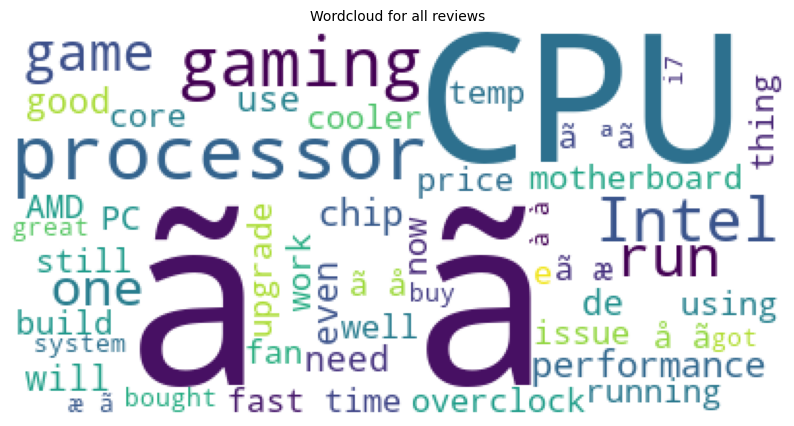

In [67]:
from wordcloud import WordCloud
# Combine all reviews
reviews = " ".join([review for review in dataset['Reviews']])
                        
# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

In [68]:
# Sentiment Analysis with Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr))



Logistic Regression Accuracy: 0.7092907092907093
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        62
           1       0.00      0.00      0.00        26
           2       0.00      0.00      0.00        48
           3       0.17      0.01      0.01       152
           4       0.71      0.99      0.83       713

    accuracy                           0.71      1001
   macro avg       0.18      0.20      0.17      1001
weighted avg       0.53      0.71      0.59      1001



C:\Users\vedik\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedik\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedik\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [69]:
# Sentiment Analysis with Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.6503496503496503
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.11      0.03      0.05        62
           1       0.00      0.00      0.00        26
           2       0.06      0.02      0.03        48
           3       0.17      0.06      0.09       152
           4       0.71      0.90      0.79       713

    accuracy                           0.65      1001
   macro avg       0.21      0.20      0.19      1001
weighted avg       0.54      0.65      0.58      1001



In [70]:
# Sentiment Analysis with SVM
svm_model = SVC()
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))


SVM Accuracy: 0.7102897102897103
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        62
           1       0.00      0.00      0.00        26
           2       0.00      0.00      0.00        48
           3       0.38      0.02      0.04       152
           4       0.71      0.99      0.83       713

    accuracy                           0.71      1001
   macro avg       0.22      0.20      0.17      1001
weighted avg       0.57      0.71      0.60      1001



C:\Users\vedik\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedik\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedik\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C:\Users\vedik\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


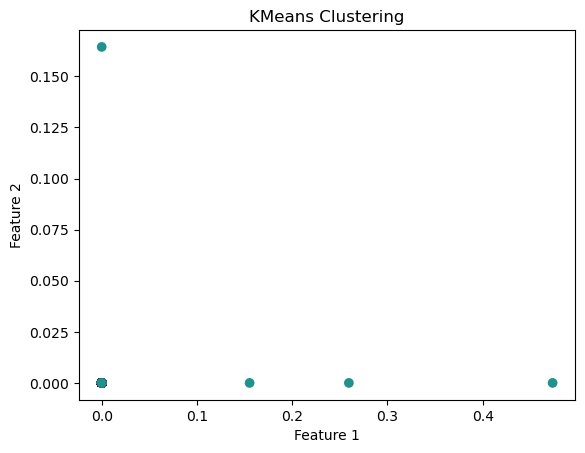

In [71]:
# Clustering Analysis
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_train)
clusters = kmeans.predict(X_test)
plt.scatter(X_test.toarray()[:, 0], X_test.toarray()[:, 1], c=clusters, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('KMeans Clustering')
plt.show()


In [87]:
# Key Features Extraction
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(dataset['Reviews'])
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(X)

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lda, vectorizer.get_feature_names_out(), 10)

positive_reviews = dataset[dataset['Ratings'] >= 4]
negative_reviews = dataset[dataset['Ratings'] < 4]


Topic 0:
intel performance cpu processor i7 core price gaming amd chip
Topic 1:
graphics card great processor good works i3 gaming itâ better
Topic 2:
product amazon box processor new com good paste fan packaging
Topic 3:
que el es en ªã para la ¾ã procesador ¼ã
Topic 4:
cpu gaming cooler runs fast running cores thing temps using
Topic 5:
le et pour est en processeur il la pas une
Topic 6:
di il che la non processore una questo prestazioni si
Topic 7:
cpu processor cooler stock fan using chip overclock don running
Topic 8:
cpu cooler gaming great just games good really like pc
Topic 9:
cpu intel ram gen motherboard build upgrade amd i5 windows


In [88]:
# Extract keywords
def extract_keywords(reviews, ngram_range=(1, 2), top_n=10):
    vectorizer = CountVectorizer(stop_words='english', ngram_range=ngram_range, max_features=1000)
    X = vectorizer.fit_transform(reviews)
    keywords = vectorizer.get_feature_names_out()
    word_counts = X.sum(axis=0).A1
    word_freq = dict(zip(keywords, word_counts))
    sorted_keywords = sorted(word_freq.items(), key=lambda item: item[1], reverse=True)
    return sorted_keywords[:top_n]

positive_keywords = extract_keywords(positive_reviews['Reviews'])
negative_keywords = extract_keywords(negative_reviews['Reviews'])


In [89]:
# Display keywords
print("1. Positive Keywords:")
for word, freq in positive_keywords:
    print(f"{word}: {freq}")

print("\n2. Negative Keywords:")
for word, freq in negative_keywords:
    print(f"{word}: {freq}")

positive_keywords = ' '.join(positive_reviews['Reviews']).split()
negative_keywords = ' '.join(negative_reviews['Reviews']).split()
positive_keywords_summary = pd.Series(positive_keywords).value_counts().head(100)
negative_keywords_summary = pd.Series(negative_keywords).value_counts().head(100)


1. Positive Keywords:
cpu: 2732
processor: 1302
gaming: 1247
intel: 1180
cooler: 916
great: 823
good: 812
i7: 766
just: 757
performance: 755

2. Negative Keywords:
cpu: 322
gaming: 149
processor: 149
intel: 147
i7: 112
performance: 106
cooler: 101
great: 98
good: 94
just: 88


C:\Users\vedik\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 132 (\x84) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


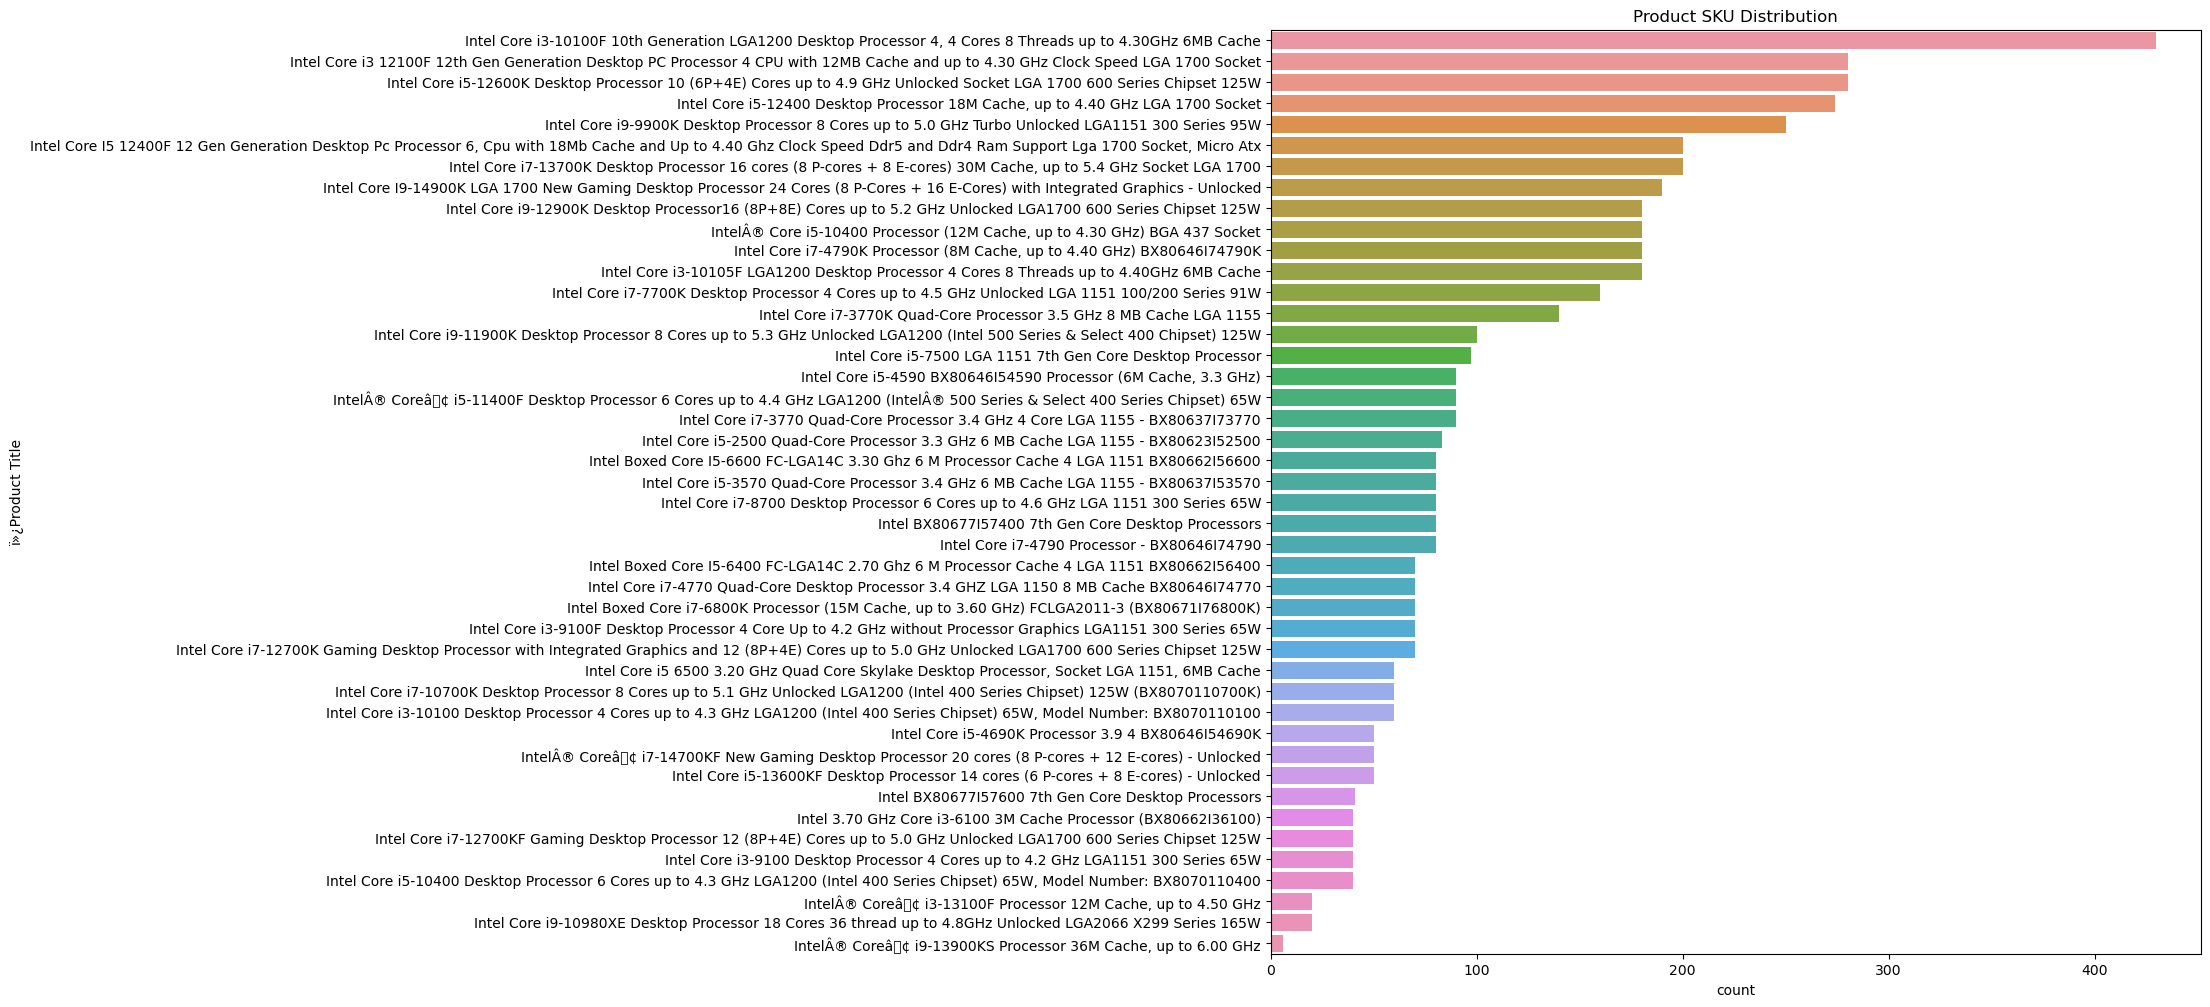

In [92]:
def visualize_sku_distribution(dataset):
    plt.figure(figsize=(12, 12))
    sns.countplot(y='ï»¿Product Title', data=dataset, order=dataset['ï»¿Product Title'].value_counts().index)
    plt.title('Product SKU Distribution')
    plt.show()
visualize_sku_distribution(dataset)


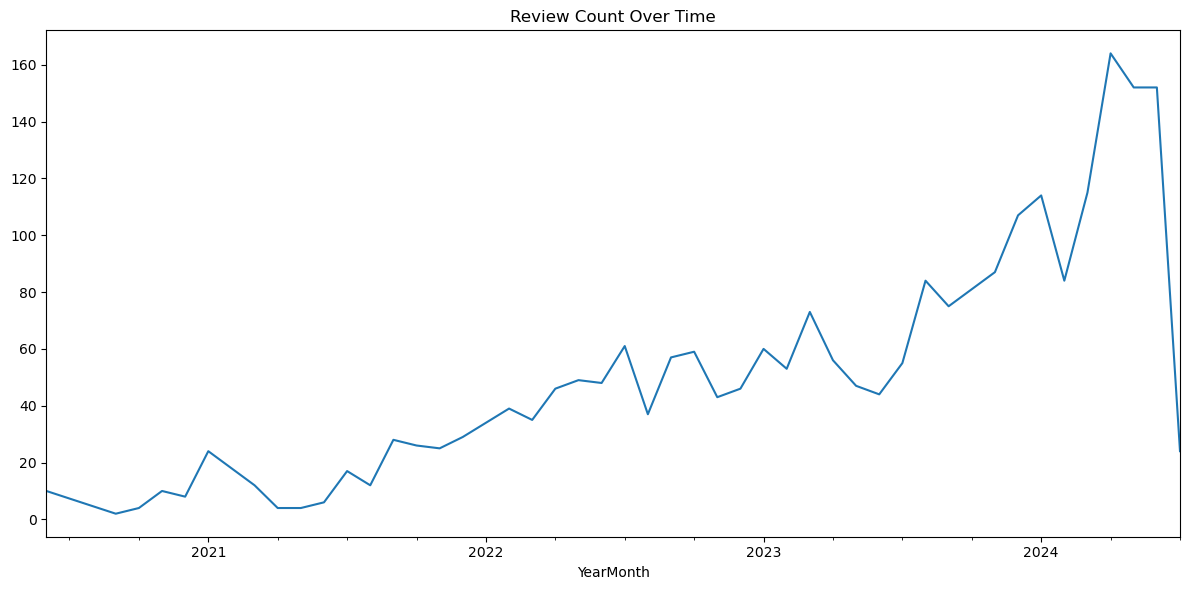

In [93]:
def visualize_timeline(dataset):
    dataset['Review Date'] = pd.to_datetime(dataset['Review Date'])
    dataset['YearMonth'] = dataset['Review Date'].dt.to_period('M')
    timeline = dataset.groupby('YearMonth').size()
    timeline.plot(kind='line', figsize=(12, 6))
    plt.title('Review Count Over Time')
    plt.tight_layout()
    plt.show()
visualize_timeline(dataset)


C:\Users\vedik\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 159 (\x9f) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\vedik\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 145 (\x91) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\vedik\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 141 (\x8d) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\vedik\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 152 (\x98) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\vedik\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 132 (\x84) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\vedik\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 151 (\x97) missing from current font

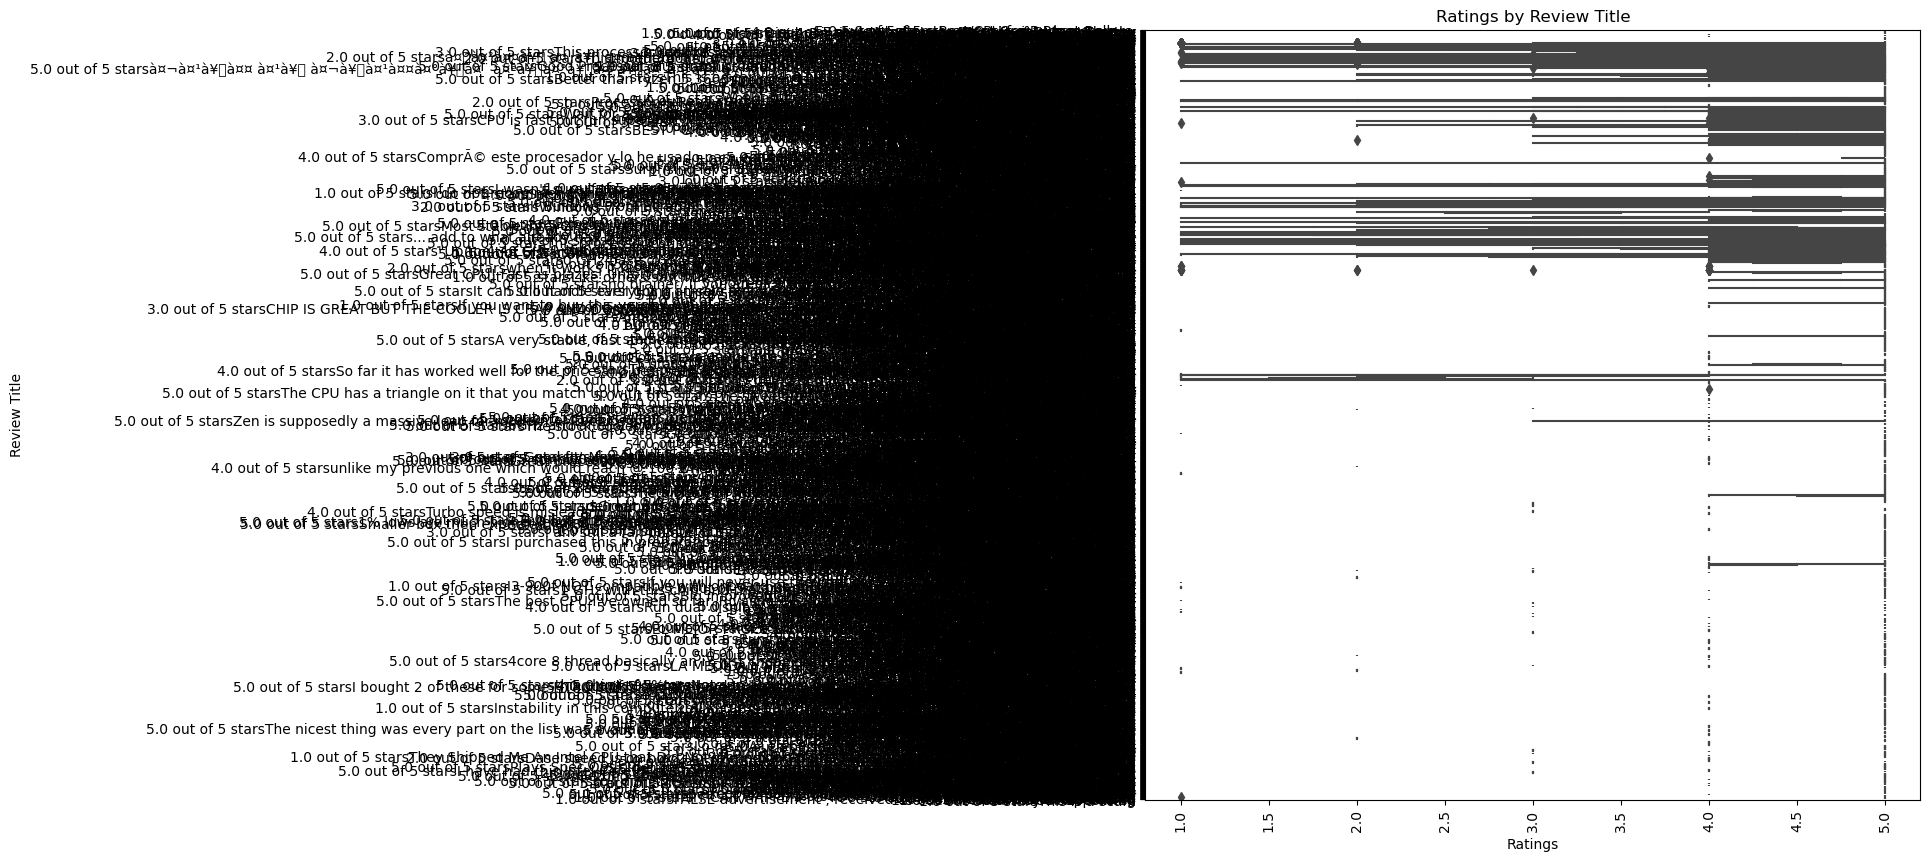

In [94]:
def visualize_technical_features(dataset):
    plt.figure(figsize=(10, 10))
    sns.boxplot(x='Ratings', y='Review Title', data=dataset)
    plt.title('Ratings by Review Title')
    plt.xticks(rotation=90)
    plt.show()
visualize_technical_features(dataset)


In [97]:
# Calculate sentiment trends over time
sentiment_trends = dataset.groupby('Year')['Ratings'].mean()

print("\n3. Sentiment Trends Over Time:")
print(sentiment_trends)


3. Sentiment Trends Over Time:
Year
2020.0    4.617647
2021.0    4.443902
2022.0    4.388087
2023.0    4.416058
2024.0    4.423602
Name: Ratings, dtype: float64


In [98]:
# Generate recommendations
print("Summary and Recommendations:\n")



Summary and Recommendations:



In [99]:
# Summary of positive keywords
print("1. Positive Keywords:")
print(positive_keywords_summary)


1. Positive Keywords:
the      8141
a        6554
and      6261
I        5840
to       5424
         ... 
over      353
chip      348
don't     347
it.       344
runs      344
Name: count, Length: 100, dtype: int64


In [100]:
# Summary of negative keywords
print("\n2. Negative Keywords:")
print(negative_keywords_summary)



2. Negative Keywords:
the     912
a       792
and     768
I       658
to      609
       ... 
what     44
do       44
need     43
il       43
una      43
Name: count, Length: 100, dtype: int64


In [101]:
# Performance Metrics
models = ['Logistic Regression', 'Random Forest', 'SVM']
accuracies = [accuracy_score(y_test, y_pred_lr), accuracy_score(y_test, y_pred_rf), accuracy_score(y_test, y_pred_svm)]
precisions = [precision_recall_fscore_support(y_test, y_pred_lr, average='weighted')[0],
              precision_recall_fscore_support(y_test, y_pred_rf, average='weighted')[0],
              precision_recall_fscore_support(y_test, y_pred_svm, average='weighted')[0]]
recalls = [precision_recall_fscore_support(y_test, y_pred_lr, average='weighted')[1],
           precision_recall_fscore_support(y_test, y_pred_rf, average='weighted')[1],
           precision_recall_fscore_support(y_test, y_pred_svm, average='weighted')[1]]
f1_scores = [precision_recall_fscore_support(y_test, y_pred_lr, average='weighted')[2],
             precision_recall_fscore_support(y_test, y_pred_rf, average='weighted')[2],
             precision_recall_fscore_support(y_test, y_pred_svm, average='weighted')[2]]
performance_metrics = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores
})
print("\nModel Performance Metrics:")
print(performance_metrics)



Model Performance Metrics:
                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.709291   0.532858  0.709291  0.593271
1        Random Forest  0.650350   0.540174  0.650350  0.581845
2                  SVM  0.710290   0.565310  0.710290  0.597248


C:\Users\vedik\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedik\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedik\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedik\anaconda3\Lib\site-packages\sklearn\metr

In [103]:
#Need to do some changes
positive_reviews = dataset[dataset['sentiment_label'] == 'positive']
negative_reviews = dataset[dataset['sentiment_label'] == 'negative']
recommendations = {
    "Improve Cooling system": len([review for review in negative_reviews['Reviews'] if 'crashes' in review]),
    "Improve performance": len([review for review in negative_reviews['Reviews'] if 'stability' in review]),   #look for recommendation
    "Enhance heat sink capacity": len([review for review in negative_reviews['Reviews'] if 'cpu' in review]),
}

In [104]:
#need to do some changes
print("Recommendations for Improvement:")
for key, value in recommendations.items(): #It is working
    print(f"{key}: {value} mentions")


Recommendations for Improvement:
Improve Cooling system: 6 mentions
Improve performance: 15 mentions
Enhance heat sink capacity: 87 mentions


In [105]:
# Recommendations based on analysis
print("\nRecommendations:\n")
print("1. Focus on improving aspects frequently mentioned in negative reviews to increase customer satisfaction.")
print("2. Maintain and enhance features highlighted in positive reviews to retain positive sentiment.")
print("3. Analyze the performance of different product categories to identify strengths and areas for improvement.")
print("4. Continuously monitor sentiment trends to adapt to changing customer needs and preferences.")
print("5. Consider advanced NLP techniques like BERT for better performance in sentiment analysis.")



Recommendations:

1. Focus on improving aspects frequently mentioned in negative reviews to increase customer satisfaction.
2. Maintain and enhance features highlighted in positive reviews to retain positive sentiment.
3. Analyze the performance of different product categories to identify strengths and areas for improvement.
4. Continuously monitor sentiment trends to adapt to changing customer needs and preferences.
5. Consider advanced NLP techniques like BERT for better performance in sentiment analysis.


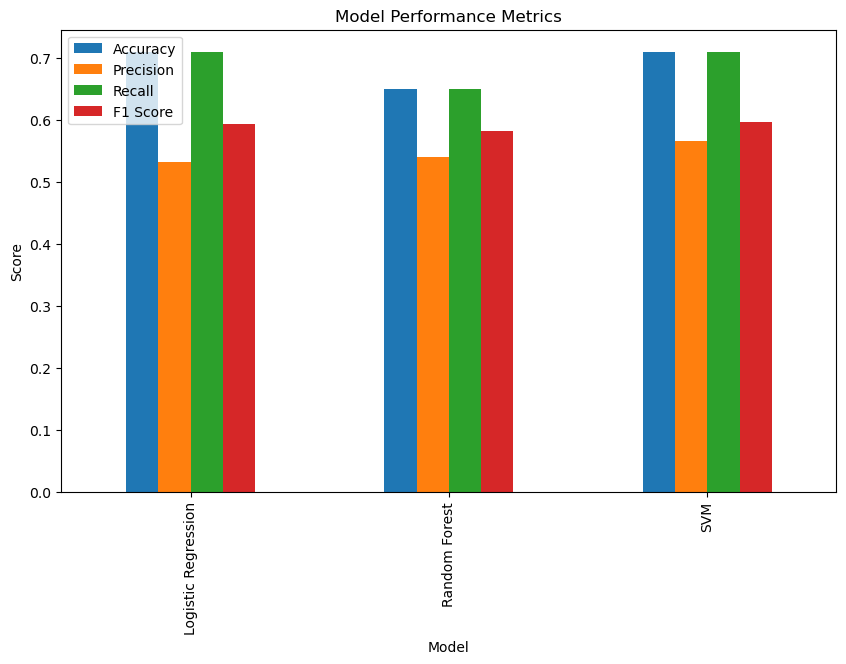

In [106]:
# Visualization of performance metrics
performance_metrics.plot(kind='bar', x='Model', y=['Accuracy', 'Precision', 'Recall', 'F1 Score'], figsize=(10, 6))
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.xlabel('Model')
plt.show()
# Export results to a CSV file
performance_metrics.to_csv('model_performance_metrics.csv', index=False)



In [107]:
# Improved Feature Extraction
def categorize_product(title):
    if 'Mobile Processor' in title or 'Laptop Processor' in title:
        return 'Mobile Processor'
    elif 'Desktop Processor' in title:
        return 'Desktop Processor'
    else:
        return 'Other'

dataset['Product Category'] = dataset['ï»¿Product Title'].apply(categorize_product)

# Display the first few rows to check the categories
print(dataset['Product Category'].value_counts())

Product Category
Desktop Processor    3262
Other                1739
Name: count, dtype: int64


In [108]:
#######################################################################################

In [109]:
# Save performance metrics and summary
with open("performance_metrics(final).txt", "w") as f:
    f.write("Logistic Regression Accuracy: " + str(accuracy_score(y_test, y_pred_lr)) + "\n")
    f.write(classification_report(y_test, y_pred_lr) + "\n")
    f.write("Random Forest Accuracy: " + str(accuracy_score(y_test, y_pred_rf)) + "\n")
    f.write(classification_report(y_test, y_pred_rf) + "\n")
    f.write("SVM Accuracy: " + str(accuracy_score(y_test, y_pred_svm)) + "\n")
    f.write(classification_report(y_test, y_pred_svm) + "\n")
    

C:\Users\vedik\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedik\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedik\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedik\anaconda3\Lib\site-packages\sklearn\metr

In [110]:
summary = {
    "Most Mentioned Positive Aspects": positive_reviews['Reviews'].value_counts().head(5).index.tolist(),
    "Most Mentioned Negative Aspects": negative_reviews['Reviews'].value_counts().head(5).index.tolist(),
    "Recommendations": recommendations
}

In [111]:
with open("summary_and_recommendations(final).txt", "w") as f:
    f.write(str(summary))

In [112]:
dataset['review_length'] = dataset['Reviews'].apply(lambda x: len(x.split()))
print(dataset['review_length'].describe())


count    5001.000000
mean       63.923215
std        86.997288
min         1.000000
25%        12.000000
50%        35.000000
75%        87.000000
max      1377.000000
Name: review_length, dtype: float64
